In [1]:
from __future__ import print_function

import os
import sys
import time

import torch
print(torch.__version__)
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,MinMaxScaler

import numpy as np
from math import floor

from sklearn.model_selection import KFold
import pandas as pd

from bayes_opt import BayesianOptimization

#import scripts
import importlib as importlib
sys.path.append(os.path.abspath('./helper_functions'))
import helper_functions.compute_stats as compute_stats
import helper_functions.generate_images as generate_images
import helper_functions.helper_functions as helper_functions
import helper_functions.import_data as import_data
import helper_functions.plot_data as plot_data
import helper_functions.load_data as load_data

#set gpu env
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device",device)
print("cuda version",torch.version.cuda)


2.3.0+cu121
2.3.0+cu121
2.3.0+cu121
2.3.0+cu121
Device cuda:0
cuda version 12.1


Init Financial Data

In [2]:
#key inputs for quick runs
scenario = 0
run_train = 1

#stock_ticker = 'MSFT'
#stock_ticker = 'SICP'
train_stock_ticker = 'SIVBQ'
index_ticker = '^SP500-40'

#close price time period
start_date = '2021-12-05'
#start_date = '2021-10-01'
#end_date = '2023-12-02'
#end_date = '2022-02-15'
end_date = '2023-01-25'


Init Hyper-parameters

In [3]:
#time series to image transformation algorithm: GRAMIAN 1; MARKOV 2
transform_algo_type = 1
transform_algo = generate_images.TransformAlgo.from_value(transform_algo_type)
print("Image transformation algo type",transform_algo)

#gaf image inputs
gaf_method="summation"
transformed_img_sz=32
sample_range = (0, 1)

#GRAMIAN/MARKOV: image transformation scale
#scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()

# training's test size
test_size=0.5

#Default hyperparameters

filter_size_1=(2, 3)
filter_size_2=(2, 2)
filter_size_3=(2, 3)

stride=2

output_conv_1=40#180#40
output_conv_2=12#180
output_FC_1=100#40
output_FC_2=70
final_FCLayer_output=1

learning_rate= 0.00001#0.0001#0.000001#0.000001#0.001#0.000001=0.56;0.00001=0.15
momentum = 0.9

dropout_probab=0.5

batch_size =16

num_epochs_input = 10000

loss_threshold = 0.0001#0.000001

transform = generate_images.SetTransform(normalize_ftor=0.5, resolution_x=32, resolution_y=32)

Image transformation algo type TransformAlgo.GRAMIAN


Init Hyper-parameters

## Import Financial Data

In [4]:
#import stock dataset
stock_dataset_df = import_data.import_dataset(train_stock_ticker, start_date, end_date)
stock_dataset_df.head()

[*********************100%%**********************]  1 of 1 completed

Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00


,Open,Close,High,Low
Date,,,,
2021-12-06,688.940002,693.390015,704.645020,682.325012
2021-12-07,701.489990,716.780029,720.419983,700.859985
2021-12-08,724.000000,710.210022,726.830017,705.020020
2021-12-09,706.000000,706.059998,714.320007,703.390015
2021-12-10,711.099976,703.919983,717.375000,692.780029


Graph to compare rebased prices with the S&P Financials index

[*********************100%%**********************]  1 of 1 completed


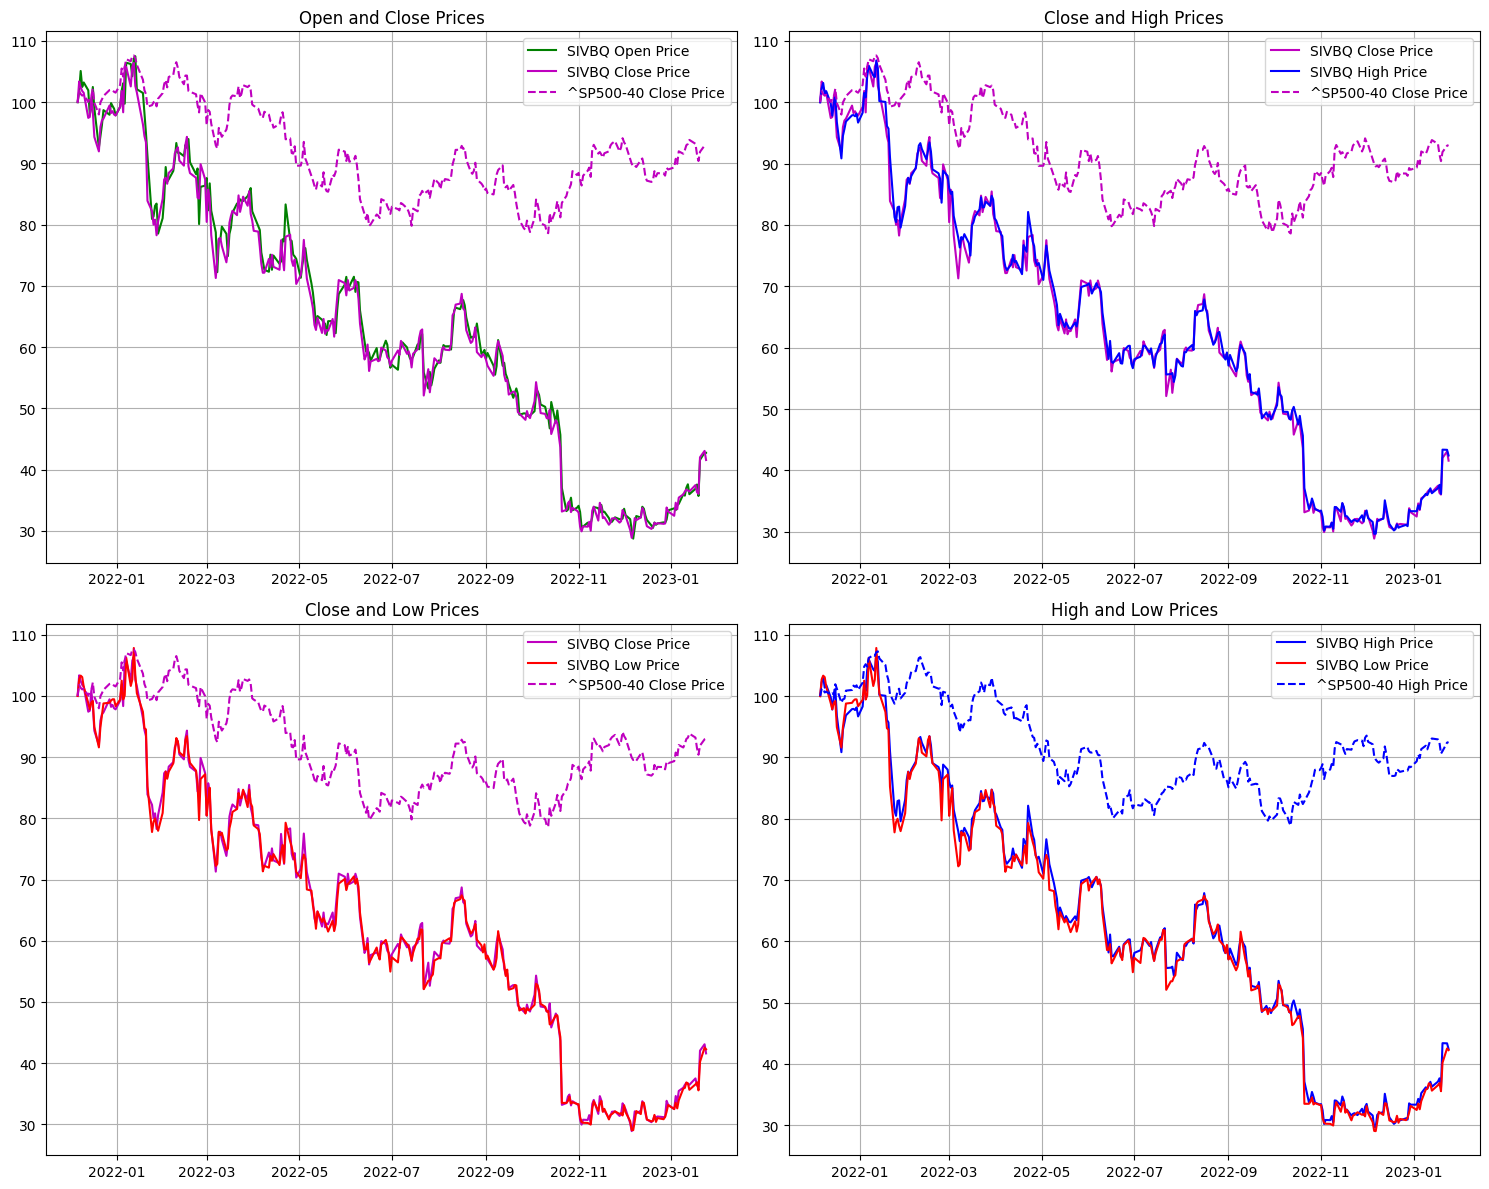

In [5]:
plot_data.compare_stocks(index_ticker,train_stock_ticker,stock_dataset_df, start_date, end_date)

## Imaging Algorithm: Generate Gramian angular field (GAF) images from time series data 
Uses popular time series imaging algorithm in [pyts' GramianAngularField method](https://pyts.readthedocs.io/en/stable/auto_examples/image/plot_single_gaf.html)

GAF represents time series in a polar coordinate system instead of the typical Cartesian coordinates by considering the trigonometric sum or difference between stock prices and calculate the correlation within different time intervals. [Source.](https://towardsdatascience.com/rgb-gaf-image-a-possible-solution-to-one-weak-point-of-gramian-angular-field-imaging-ffc6b31edfbe)

[Making Gram matrix CNN ready](https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3)

Gramian Matrix of a set of n vectors:

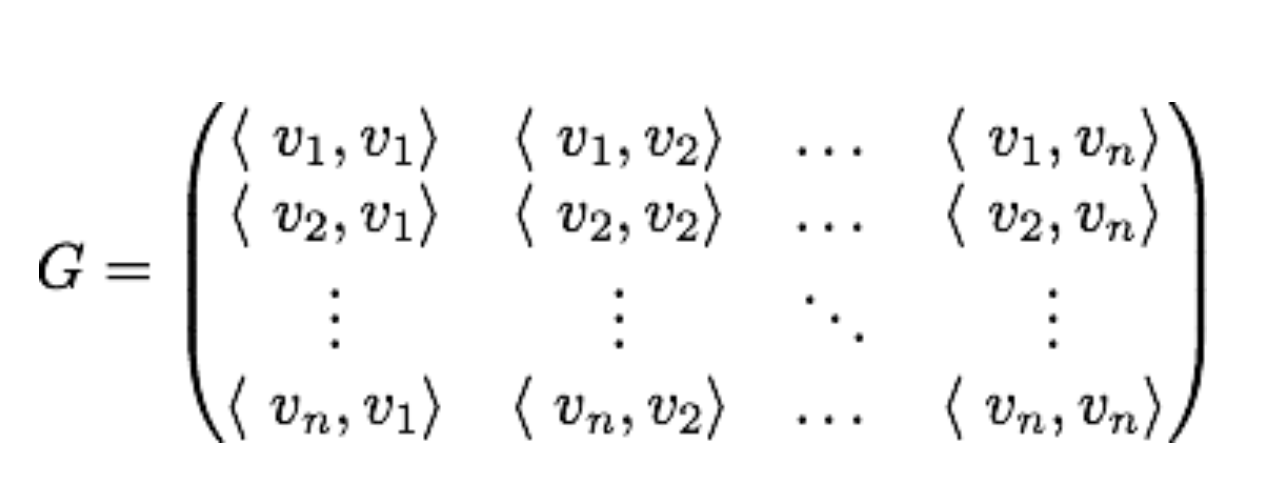

Gramian Matrix of units vector where Φ(i, j) is the angle between vectors i and j

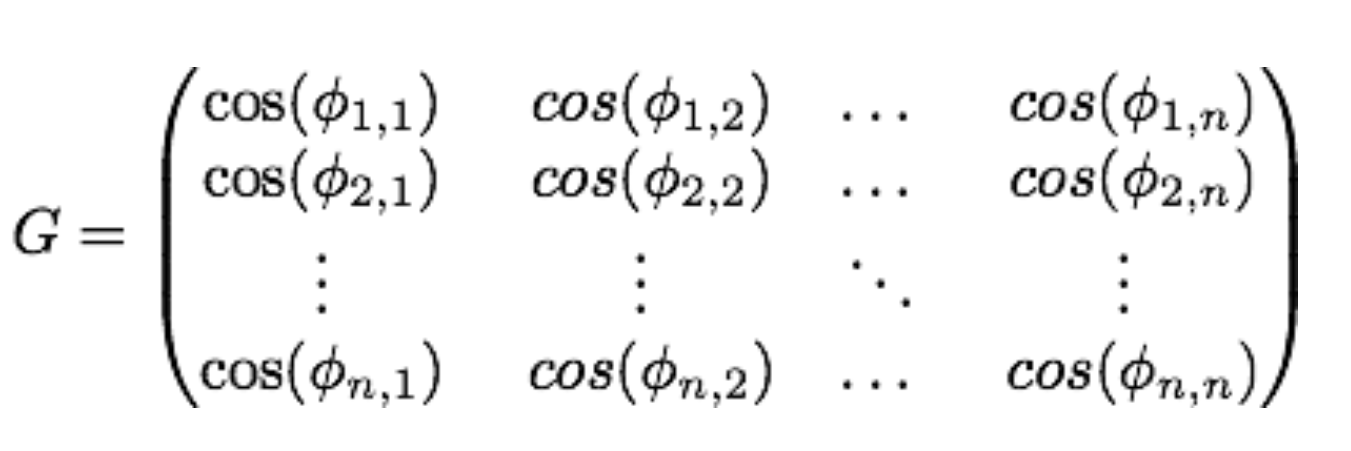

Therefore the dot product operation in GAF provides us with the correlation between each set of observations whilst preserving the temporal relationship. To account for the bias introduced from the inner product between two distinct observations or an observation with itself, a further summation or difference matrix (GASF or GADF) transformation is applied. In this notebook we apply summation.

Since GAF provides the combination of the datapoints requested, each image of size 32 in this notebook, the dot product combination of 32 data points yields 1024 points in an image (32x32 image). Since we request GAF images of size 32x32, we can calculate the number of images GAF will generate for one feature (e.g. closing price time series), in the example images below 524 data points / 32 = 16 images; thus 524 data points yield 16,384 gaf values represented over 16 images size 32x32.

## Visualize Closing Price for one image in GAF
A darker patch indicates lower correlation between the different elements of the price time series, possibly due to higher volatility or noise. The opposite is true for the lighter patches.

In [6]:
full_feature_data = np.array(stock_dataset_df['Close'])
print(len(stock_dataset_df['Close']))
#print("feature_dataset_array",feature_data)

print("len datapoints in dataset",len(full_feature_data), "images generated", int(len(full_feature_data)/transformed_img_sz))

np.set_printoptions(threshold=np.inf)
transformed_images = generate_images.generate_transformed_images(full_feature_data, transform_algo, gaf_img_sz=transformed_img_sz, method=gaf_method)

print("transformed_images.shape",transformed_images.shape)
#plt.imshow(gaf_images[0],cmap='hot')
#print("gaf_images.shape",gaf_images.shape,"data points in images",gaf_images.size, "gaf image [0] shape",gaf_images[0].shape, "data points in image [0]",gaf_images[0].size)
#print("gasf image[0] data",gaf_images[0])
#print("Gasf data",gasf_images)

np.set_printoptions()

285
len datapoints in dataset 285 images generated 8
transformed_images.shape (8, 32, 32)


## Generate images for open, high, low, close

We transpose the resulting image list to represent:
+ 15: number of images
+ 4: number of image channels/features. Each image has 5 ="Open", "High", "Low", "Close"
+ 32: image height
+ 32: image width
+ the label is the 32+1 price for each time series chunk (image) corresponding to the relevant feature

In [7]:
#Generate images from dataset
cols_used = ["Open", "High", "Low", "Close"]
cols_used_count = sum(column_name in cols_used for column_name in stock_dataset_df.columns)
feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list = generate_images.generate_multiple_feature_images(stock_dataset_df, cols_used, transform_algo, image_size=transformed_img_sz, method=gaf_method, sample_range=sample_range)
#print("image data",feature_image_dataset_list,"labels",feature_label_dataset_list)
print("shape [0] set",np.array(feature_image_dataset_list[0]).shape)

#np.set_printoptions()

total chunks Open feature: 224
shape [0] set (1, 4, 224, 32, 32)


## Visual representation of feature images for the same time range

Bottom image averages depth values of feature images (channels)

shape images array (1, 1, 4, 224, 32, 32) shape image (32, 32)


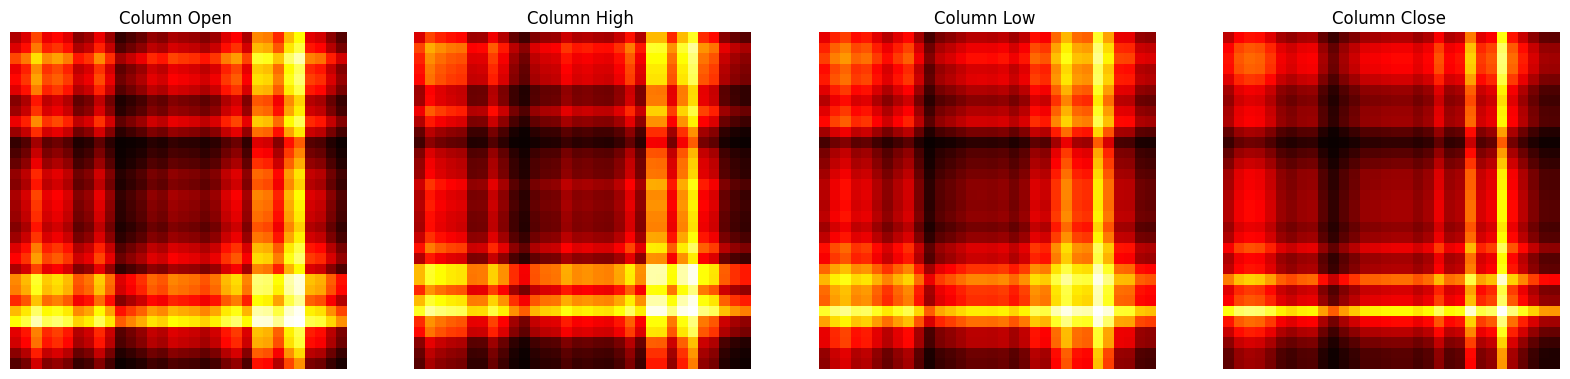

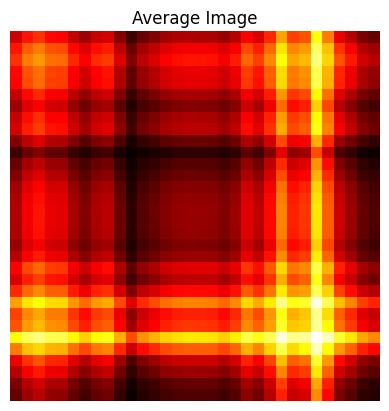

In [8]:
images_array = helper_functions.data_to_array(feature_image_dataset_list)
labels_array = helper_functions.data_to_array(feature_label_dataset_list)
# images_array=np.array(feature_image_dataset_list)
# labels_array=np.array(feature_label_dataset_list)
#print("len price array",len(prices_array),prices_array.shape,prices_array)
#print("images_array",len(images_array[0][0][0]),"labels_array",len(labels_array[0]),"prices array",len(prices_array[0][0]))
#print("len img",len(images_array),"image shape",images_array.shape)#,"prices_array[0][0]",prices_array[0][0])
#print("len label",len(labels_array),"labels shape",labels_array.shape)#,"prices_array[0][0]",prices_array[0][0])

# Plot the first image of each column
fig, axes = plt.subplots(nrows=1, ncols=cols_used_count, figsize=(20, 6))
for ax in axes:
    ax.set_aspect('equal')

#EXPLANATION SHAPE
#shape images array (1, 1, 4, 480(=15 chunks * 32 windows), 32, 32)
#I get 15 images (32x32) for 491 data points (491 = 524 - 33 data points for sliding windows, i.e. 32+1 for label)
#I create 32*15=480 32x32images
#print("image",images_array[0])
print("shape images array",images_array.shape,"shape image",images_array[0][0][0][0].shape)
for i in range(cols_used_count):
    axes[i].imshow(images_array[0][0][i][0], cmap='hot')
    axes[i].set_title(f"Column {cols_used[i]} ")

#average first image of all features
average_images = []
for i in range(cols_used_count):
    average_images.append(images_array[0][0][i][0])

average_image = np.mean(average_images, axis=0)

# Hide axes
for ax in axes:
    ax.axis('off')

# Plot the average image separately
plt.figure()  # Create a new figure for the average image
plt.imshow(average_image, cmap='hot')
plt.title("Average Image")
plt.axis('off')  # Hide axes
plt.show()

In [9]:
#squeeze arrays
images_array = images_array.squeeze(axis=(0, 1))
print("len img",len(images_array),"image shape",images_array.shape)#,"prices_array[0][0]",prices_array[0][0])
print("len label",len(labels_array),"labels shape",labels_array.shape)#,"prices_array[0][0]",prices_array[0][0])


len img 4 image shape (4, 224, 32, 32)
len label 4 labels shape (4, 224)


## Prepare Training/Testing Datasets for Neural Network

Apply Transform to image to convert to tensor and normalize

In [10]:
feature_image_dataset_list_f32, labels_scaled_list_f32 = generate_images.Generate_feature_image_dataset_list_f32(labels_array, images_array, transformed_img_sz, scaler)

Scaler received StandardScaler()
4D image array shape (4, 224, 32, 32)
3D reshaped image array  (896, 32, 32)
labels shape (896, 1)


Prepare features data (close, high, low, etc) for Dataloader

In [11]:
train_loader,test_loader = load_data.Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, test_size, batch_size=batch_size, train_shuffle=False)

size labels 0 1024
size image 0 (1, 32, 32)
size labels 1 1
size image 1 (1,)
split data test size 0.5
len train 448 len test 448


## CNN Design

dynamically calulate the shape of layers outputs

In [12]:
def conv_output_shape_dynamic(h_w, kernel_size=(1,1), stride=1):
        h = floor( (h_w[0] - kernel_size[0])/ stride) + 1
        w = floor( (h_w[1] - kernel_size[1])/ stride) + 1
        return h, w

In [13]:
class Net(nn.Module):
    def __init__(self,name="LeNet5Blend",
                 filter_size_1=filter_size_1, filter_size_2=filter_size_2, filter_size_3=filter_size_3, stride=stride,
                 output_conv_1=output_conv_1,output_conv_2=output_conv_2, output_FC_1=output_FC_1,output_FC_2=output_FC_2,
                 image_resolution_x=32,image_resolution_y=32,final_FCLayer_outputs=final_FCLayer_output,
                 dropout_probab=dropout_probab):
        super(Net, self).__init__()
        
        if name:
            self.name = name
        self.totalparams = 0
        self.output_conv_2=output_conv_2
        self.conv_output_size=0
        print();print("Convos & dropoutP:",output_conv_1,output_conv_2, dropout_probab)
        
        #num channels input, num channels output, filter size 
        self.conv1 = nn.Conv2d(1, output_conv_1, filter_size_1,stride=1)
        self.bn1 = nn.BatchNorm2d(output_conv_1)
        #filtersize,stride.
        #maxpool acts the same way in each channel, so doesn't need to be fed the num channels of the input
        self.pool = nn.MaxPool2d(kernel_size=filter_size_2, stride=stride)
        self.conv2 = nn.Conv2d(output_conv_1, output_conv_2, filter_size_3,stride=1)
        self.bn2 = nn.BatchNorm2d(output_conv_2)

        H_out_1, W_out_1 = conv_output_shape_dynamic((image_resolution_y, image_resolution_x), kernel_size=filter_size_1,stride=1)
        H_out_2, W_out_2 = conv_output_shape_dynamic((H_out_1, W_out_1), kernel_size=filter_size_2,stride=stride)
        H_out_3, W_out_3 = conv_output_shape_dynamic((H_out_2, W_out_2), kernel_size=filter_size_3,stride=1)
        H_out_4, W_out_4 = conv_output_shape_dynamic((H_out_3, W_out_3), kernel_size=filter_size_2,stride=stride)
        
        print("imgres",image_resolution_x,image_resolution_y)
        print("H_out_1, W_out_1",H_out_1, W_out_1)
        print("H_out_2, W_out_2",H_out_2, W_out_2)
        print("H_out_3, W_out_4",H_out_3, W_out_3)
        print("H_out_4, W_out_4",H_out_4, W_out_4)
        print("outputconv2",output_conv_2)
        self.conv_output_size = H_out_4 * W_out_4

        self.fc1 = nn.Linear(output_conv_2 * self.conv_output_size, output_FC_1)
        self.bn_fc1 = nn.BatchNorm1d(output_FC_1)
        self.fc2 = nn.Linear(output_FC_1, output_FC_2)
        self.bn_fc2 = nn.BatchNorm1d(output_FC_2)
        self.fc3 = nn.Linear(output_FC_2, final_FCLayer_outputs)
        
        self.dropout1 = nn.Dropout(dropout_probab)
        self.dropout2 = nn.Dropout(dropout_probab)

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)
        self.totalparams=total_params

    def forward(self, x):
        #BatchNorm after Conv and before Pooling
        x = F.relu(self.bn1(self.conv1(x)))  
        x = self.pool(x)
        #BatchNorm after Conv and before Pooling
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(-1, self.output_conv_2 * self.conv_output_size)
        #BatchNorm after FC and before Dropout
        x = F.relu(self.bn_fc1(self.fc1(x)))
        if dropout_probab>0: x = self.dropout1(x)
        #BatchNorm after FC and before Dropout
        x = F.relu(self.bn_fc2(self.fc2(x)))
        if dropout_probab>0: x = self.dropout2(x)
        x = self.fc3(x)
        return x


        # #print("Input shape:", x.shape)
        # x = self.pool(F.relu(self.conv1(x)))
        # #print("After conv1 and pooling shape:", x.shape)
        # x = self.pool(F.relu(self.conv2(x)))
        # #print("After conv2 and pooling shape:", x.shape)
        # #-1 takes the batch size
        # x = x.view(-1,self.output_conv_2*self.conv_output_size)
        # #print("After flattening shape:", x.shape)
        # x = F.relu(self.fc1(x))
        # #print("After fc1 shape:", x.shape)
        # x = F.relu(self.fc2(x))
        # #print("After fc2 shape:", x.shape)
        # x = self.fc3(x)
        # #print("Output shape:", x.shape)
        # return x

## Train and Test CNN

Init Weights

In [14]:
def weights_init_he(m):
    if isinstance(m, nn.Conv2d):
        #mode=fan_out: Used for convolutional layers to account for the output size of the layer
        nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        #mode=fan_in: Used for linear layers to account for the input size
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

Instantiate Net

In [15]:
net = Net(name='LeNet-5 Based Net', filter_size_1=filter_size_1, filter_size_2=filter_size_2,
            filter_size_3=filter_size_3, stride=stride,
            image_resolution_x=32,image_resolution_y=32,
            output_conv_1=output_conv_1, output_conv_2=output_conv_2,
            output_FC_1=output_FC_1, output_FC_2=output_FC_2,
            final_FCLayer_outputs=final_FCLayer_output,
            dropout_probab=dropout_probab)

def print_layer_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad and 'weight' in name:
            print(f"{name}: {param.numel()} weights")

net.to(device)
net.parameters()
print_layer_weights(net)


Convos & dropoutP: 40 12 0.5
imgres 32 32
H_out_1, W_out_1 31 30
H_out_2, W_out_2 15 15
H_out_3, W_out_4 14 13
H_out_4, W_out_4 7 6
outputconv2 12
LeNet-5 Based Net: total params: 61257
conv1.weight: 240 weights
bn1.weight: 40 weights
conv2.weight: 2880 weights
bn2.weight: 12 weights
fc1.weight: 50400 weights
bn_fc1.weight: 100 weights
fc2.weight: 7000 weights
bn_fc2.weight: 70 weights
fc3.weight: 70 weights


Train CNN

In [16]:
#torch.set_printoptions(threshold=torch.inf)

#print running_loss every [x] mini-batches
epoch_running_loss_check = 500
epoch_running_gradients_check = 4000

def Train(learning_rate,momentum, train_loader, net=net):
    
    start_time = time.time()

    print(f"Train params: learning_rate: {learning_rate}, momentum:{momentum}")

    net.apply(weights_init_he)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    #criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(num_epochs_input):

        gradients_dict = {name: [] for name, _ in net.named_parameters() if 'weight' in name}

        weights_dict = {name: [] for name, _ in net.named_parameters() if 'weight' in name}

        running_loss = 0.0

        first_batch = True
        
        for i, data in enumerate(train_loader, 0):
            #print(f"Batch {i + 1}")
            #get the inputs; data is a list of [inputs, labels]
            # print("image type",type(data[0]), "shape", data[0].shape)
            # print("image size",data[0].numel())
            # print("label type",type(data[1]), "shape", data[1].shape)
            # print("label size",data[1].numel())
            #print("**zero:",data[0])
            #print("type",type(data[1]),"**one:", data[1])
            #print("label pre",data[1])
            #data[1]=data[1].type(torch.LongTensor)
            inputs, labels = data[0].to(device), data[1].to(device)
            if i==0 and epoch==0:
                print("epoch",epoch,"data i",i,"len image",len(inputs), "shape",inputs.shape)
                print("epoch",epoch,"data i",i,"label",labels,"labels shape",labels.shape)
            
            # for e in data[1]:
            #     print("label",e.item())
            #print("label",data[1].item())
            #labels = labels.long()

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            #print("outputs shape",outputs.shape,outputs)
            #print("outputs",outputs)
            loss = criterion(outputs, labels)
            if loss is not None:
                loss.backward()
                optimizer.step()

                # Print optimizer's state_dict
                # print("Optimizer's state_dict:")
                # for var_name in optimizer.state_dict():
                #     print(var_name, "\t", optimizer.state_dict()[var_name])

                # print epoch/loss
                running_loss += loss.item()
                #if i % mini_batch_running_loss_check == (mini_batch_running_loss_check-1):    # print every x mini-batches
                #changed to show less results because with 10k epochs it cloggs github repo
                #if (epoch+ 1) % epoch_running_loss_check == 0 and  i % mini_batch_running_loss_check == (mini_batch_running_loss_check-1):
                if first_batch and ((epoch + 1) % epoch_running_loss_check == 0):
                    print('[%d, %5d] Cum loss: %.9f' %
                        (epoch + 1, i + 1, running_loss / epoch_running_loss_check)) 
                    running_loss = 0.0

                if loss.item() < loss_threshold:
                    print(f"Loss is less than {loss_threshold}:{loss.item()} at {epoch}. Stopping training.")
                    return loss
                
                if first_batch and ((epoch + 1) % epoch_running_gradients_check == 0):
                    for name, param in net.named_parameters():
                        if 'weight' in name:
                            if param.grad is not None:
                                gradients_dict[name].append(param.grad.detach().cpu().numpy())
                            weights_dict[name].append(param.detach().cpu().numpy())

                    plot_data.plot_weights_gradients(weights_dict, gradients_dict, epoch)
                    first_batch = False
                    #print("epoch",epoch,"data i",i,"image",inputs)
                    #print("epoch",epoch,"data i",i,"label",labels)
                    #print("epoch",epoch,"outputs i",i,"outputs",outputs)
    
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.6f} seconds")
                
    return loss

#torch.set_printoptions()

In [ ]:
if run_train == 1:
    loss = Train(learning_rate, momentum, train_loader, net=net)
    print(loss)

In [18]:
if run_train == 1:
    helper_functions.Save_Scenario_State_Model(scenario,net)
    helper_functions.Save_Scenario_Full_Model(scenario,net)

In [19]:
if run_train != 1:
    PATH = f'./model_scen_{0}_full.pth'
    net = helper_functions.Load_Full_Model(PATH)

## Test CNN Results

Test Results

In [20]:
#set model for evaluation
net.eval()

Net(
  (conv1): Conv2d(1, 40, kernel_size=(2, 3), stride=(1, 1))
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 12, kernel_size=(2, 3), stride=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=504, out_features=100, bias=True)
  (bn_fc1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=70, bias=True)
  (bn_fc2): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=70, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [21]:
def calculate_iqr(tensor_list):
    stack = torch.stack(tensor_list, dim=1)
    for stack_tensor in stack:
        #print("stack_tensor shape",stack_tensor.shape)
        Q1 = np.percentile(stack_tensor, 25)
        Q3 = np.percentile(stack_tensor, 75)
        IQR = Q3 - Q1
    
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        data_iqr = [x for x in stack_tensor if lower_bound <= x <= upper_bound]
        #print("dataiqr",data_iqr)
        error_pct_outside_iqr = ((len(stack_tensor) - len(data_iqr)) / len(stack_tensor)) * 100
        #print("len dataiqr",len(data_iqr))
        #print("dropped",percentage_dropped)

    return data_iqr, error_pct_outside_iqr

In [22]:
def calculate_score(tensor_list):
    #print("tensor_list",tensor_list)
    stack = torch.stack(tensor_list, dim=1)
    #print("len stack",len(stack.data[0]))
    #print("true_sum",torch.sum(stack,dim=1))
    true_sum = torch.sum(stack,dim=1)
    score = (true_sum/len(stack.data[0]))*100
    #print("score in",score)
    return score

In [23]:
importlib.reload(compute_stats)
importlib.reload(plot_data)
importlib.reload(generate_images)
importlib.reload(load_data)
importlib.reload(import_data)
importlib.reload(helper_functions)
#time series to image transformation algorithm
transform_algo = generate_images.TransformAlgo.from_value(transform_algo_type)

def Test(test_loader, net=net):
    inputs_list = []
    accuracy = 0
    correct_2dp_list = []
    correct_1dp_list = []
    error_list = []
    #dataframe vars
    predicted_list = []
    actual_list = []
    abs_percentage_diffs_list = []
    stack_input=None
    stack_predicted=None

    torch.set_printoptions(threshold=torch.inf)

    for i, data in enumerate(test_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = net(inputs)
        
        input_tensor = inputs.data
        predicted_tensor = outputs.data
        actual_tensor = labels.data
        
        input_tensor_cpu = input_tensor.cpu().detach()
        inputs_list.append(input_tensor_cpu)

        predicted_tensor_cpu = predicted_tensor.cpu().detach()
        predicted_list.append(predicted_tensor_cpu)

        actual_tensor_cpu = actual_tensor.cpu().detach()
        actual_list.append(actual_tensor_cpu)
        
        #calculate batch pct difference
        batch_abs_percentage_diff = (torch.abs(predicted_tensor - actual_tensor) / torch.abs(actual_tensor)) * 100
        abs_percentage_diffs_list.extend(batch_abs_percentage_diff.cpu().detach().numpy().flatten())

        #Check IQR
        error_tensor = (predicted_tensor - actual_tensor).cpu().detach()
        error_list.append(error_tensor)
        
        #accuracy
        correct_2dp_tensor = (torch.abs(predicted_tensor - actual_tensor)<= 0.01).cpu().detach()
        correct_2dp_list.append(correct_2dp_tensor)
        
        correct_1dp_tensor = (torch.abs(predicted_tensor - actual_tensor)<= 0.1).cpu().detach()
        correct_1dp_list.append(correct_1dp_tensor)

    torch.set_printoptions()

    correct_2dp_score = calculate_score(correct_2dp_list)
    correct_1dp_score = calculate_score(correct_1dp_list)

    print("shape",correct_1dp_score.shape)
    mean_of_mean_correct_2dp_score = torch.mean(correct_2dp_score, dim=0)
    mean_of_mean_correct_1dp_score = torch.mean(correct_1dp_score, dim=0)
    
    error_list_iqr, error_pct_outside_iqr = calculate_iqr(error_list)

    print("error_pct_outside_iqr",error_pct_outside_iqr)

    stack_input = torch.stack(inputs_list, dim=0)
    
    #actual and predicted mean
    # print("actual list",actual_list)
    # print("predicted list",predicted_list)
    stack_actual = torch.stack(actual_list, dim=0)
    #print("stack actual shape",stack_actual.shape,"stack actual",stack_actual)

    stack_predicted = torch.stack(predicted_list, dim=0)
    print("stack predicted shape",stack_predicted.shape)#,"stack_predicted",stack_predicted)
    print("stack input shape",stack_input.shape)#,"stack_input",stack_input)
        
    accuracy = [correct_2dp_score, correct_1dp_score]
    print(); print(f"Mean accuracy 2 decimal places: {mean_of_mean_correct_2dp_score}%, "
            f"Mean accuracy 1 decimal places: {mean_of_mean_correct_1dp_score}%,\n",
            f"Percentage of predictions within ",
            f"2 decimal places: {correct_2dp_score}%, "
            f"1 decimal places: {correct_1dp_score}%,\n")
            # f"average actual shape: {stack_actual.shape} values: {(torch.mean(stack_actual, dim=1))}, "
            # f"average predicted shape: {stack_predicted.shape} values: {(torch.mean(stack_predicted, dim=1))}")

    #print("abs_percentage_diffs",abs_percentage_diffs_np)
    return stack_input, predicted_list, actual_list, accuracy, stack_actual, stack_predicted

2.3.0+cu121
2.3.0+cu121
2.3.0+cu121


shape torch.Size([16, 1])
error_pct_outside_iqr 0.0
stack predicted shape torch.Size([28, 16, 1])
stack input shape torch.Size([28, 16, 1, 32, 32])

Mean accuracy 2 decimal places: tensor([3.7946])%, Mean accuracy 1 decimal places: tensor([23.8839])%,
 Percentage of predictions within  2 decimal places: tensor([[ 3.5714],
        [ 3.5714],
        [ 7.1429],
        [ 3.5714],
        [10.7143],
        [ 3.5714],
        [ 3.5714],
        [ 3.5714],
        [ 0.0000],
        [ 3.5714],
        [ 0.0000],
        [ 3.5714],
        [ 0.0000],
        [ 3.5714],
        [ 7.1429],
        [ 3.5714]])%, 1 decimal places: tensor([[14.2857],
        [21.4286],
        [28.5714],
        [39.2857],
        [35.7143],
        [25.0000],
        [25.0000],
        [32.1429],
        [ 3.5714],
        [17.8571],
        [25.0000],
        [17.8571],
        [21.4286],
        [25.0000],
        [35.7143],
        [14.2857]])%,



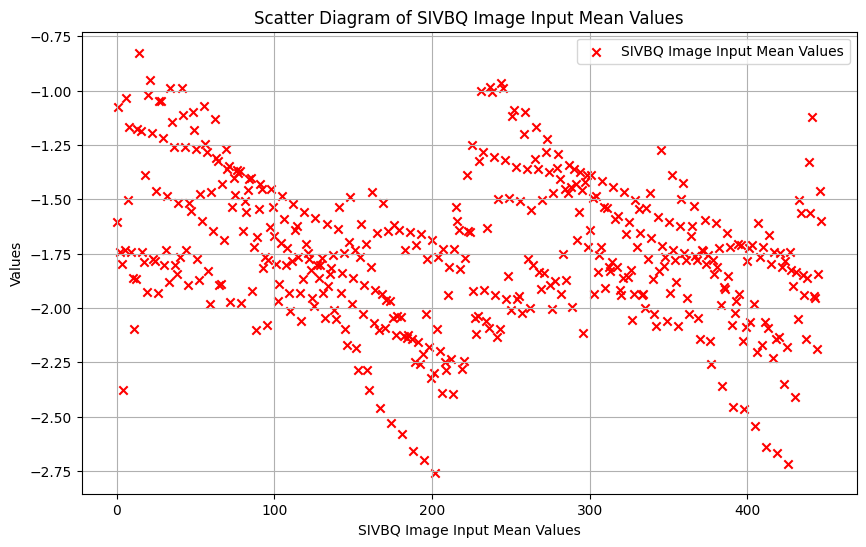

In [24]:
stack_input, predicted_list, actual_list, accuracy, stack_actual, stack_predicted  = Test(test_loader,net=net)

plot_data.scatter_diagram_onevar_plot_mean(stack_input, train_stock_ticker)

In [25]:
#compute stats
error_stats = compute_stats.compute_error_stats(stack_actual, stack_predicted)
for key, value in error_stats.items():
    print(f'{key}: {value}\n')

MAE: 0.30382832884788513

MSE: 0.16759808361530304

RMSE: 0.4093874394893646

MAPE: 120.72093200683594

R2: 0.8320767879486084



In [26]:
#write to file
output_string = (f"Accuracy 2dp: {accuracy[0]}%\n"
                 f"Accuracy 1dp: {accuracy[1]}%\n")

helper_functions.Scenario_Log(output_string)

Test Model with a Different Stock timer series

In [27]:
#set size from inputs to use as testing: 1 for all
time_series_used_to_test = 1.0
test_size = time_series_used_to_test

#test_stock_ticker = 'MSFT'
test_stock_ticker = 'SICP'
index_ticker = 'SIVBQ'
#index_ticker = '^SP500-40'

#close price time period
start_date = '2021-12-05'
#start_date = '2021-10-01'
#end_date = '2023-12-02'
#end_date = '2022-02-15'
end_date = '2023-01-25'

In [28]:
importlib.reload(compute_stats)
importlib.reload(plot_data)

#load model
PATH = f'./model_scen_{0}_full.pth'
net = helper_functions.Load_Full_Model(PATH)

#import stock dataset
stock_dataset_df = import_data.import_dataset(test_stock_ticker, start_date, end_date)

#Generate images from dataset
#cols_used = ["Open", "High", "Low", "Close"]
cols_used = ["Open", "High"]
cols_used_count = sum(column_name in cols_used for column_name in stock_dataset_df.columns)
feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list = generate_images.generate_multiple_feature_images(stock_dataset_df, cols_used, transform_algo, image_size=transformed_img_sz, method=gaf_method, sample_range=sample_range)
#print("image data",feature_image_dataset_list,"labels",feature_label_dataset_list)

#images to list and squeeze
images_array = helper_functions.data_to_array(feature_image_dataset_list)
labels_array = helper_functions.data_to_array(feature_label_dataset_list)
#squeeze arrays
images_array = images_array.squeeze(axis=(0, 1))
print("len img",len(images_array),"image shape",images_array.shape)#,"prices_array[0][0]",prices_array[0][0])
print("len label",len(labels_array),"labels shape",labels_array.shape)#,"prices_array[0][0]",prices_array[0][0])

#transform to tensor
feature_image_dataset_list_f32, labels_scaled_list_f32 = generate_images.Generate_feature_image_dataset_list_f32(labels_array, images_array, transformed_img_sz, scaler)

#generate data loaders
train_loader,test_loader = load_data.Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, test_size, batch_size=batch_size)

#test and report
test_stack_input, predicted_list, actual_list, accuracy, stack_actual, stack_predicted  = Test(test_loader,net=net)

2.3.0+cu121
Loading Full Model


[*********************100%%**********************]  1 of 1 completed

Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00
total chunks Open feature: 224
len img 2 image shape (2, 224, 32, 32)
len label 2 labels shape (2, 224)
Scaler received StandardScaler()
4D image array shape (2, 224, 32, 32)
3D reshaped image array  (448, 32, 32)
labels shape (448, 1)
size labels 0 1024
size image 0 (1, 32, 32)
size labels 1 1
size image 1 (1,)
split data test size 1.0
len train 0 len test 448
shape torch.Size([16, 1])


error_pct_outside_iqr 0.0
stack predicted shape torch.Size([28, 16, 1])
stack input shape torch.Size([28, 16, 1, 32, 32])

Mean accuracy 2 decimal places: tensor([1.3393])%, Mean accuracy 1 decimal places: tensor([11.8304])%,
 Percentage of predictions within  2 decimal places: tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [3.5714],
        [3.5714],
        [0.0000],
        [3.5714],
        [0.0000],
        [0.0000],
        [3.5714],
        [0.0000],
        [3.5714],
        [3.5714]])%, 1 decimal places: tensor([[14.2857],
        [ 7.1429],
        [ 7.1429],
        [ 0.0000],
        [17.8571],
        [17.8571],
        [17.8571],
        [14.2857],
        [ 7.1429],
        [10.7143],
        [ 7.1429],
        [ 7.1429],
        [ 7.1429],
        [10.7143],
        [25.0000],
        [17.8571]])%,



In [29]:
# report stats results

#print("test_stack_input.shape",test_stack_input.shape,"test_stack input",test_stack_input)
#compute correl prices
compute_stats.stock_correlation_matrix(test_stock_ticker, stock_dataset_df)
#compute correl images
print("trained input image shape",stack_input.shape,"test input image shape",test_stack_input.shape)
image_series_correlations, image_series_mean_correlation = compute_stats.cross_stock_image_array_correlation2(test_stack_input,stack_input)

#compute cross correl
benchmark_stock_df = import_data.import_dataset(index_ticker, start_date, end_date)
compute_stats.cross_stock_df_correlation(test_stock_ticker,index_ticker,stock_dataset_df, benchmark_stock_df)

#compute stats
error_stats = compute_stats.compute_error_stats(stack_actual, stack_predicted)
print(f"Inference Model Stats for {test_stock_ticker}")
for key, value in error_stats.items():
    print(f'{key}: {value}')

[*********************100%%**********************]  1 of 1 completed

Stock Correlation SICP
           Open     Close      High       Low
Open   1.000000  0.992518  0.997639  0.996629
Close  0.992518  1.000000  0.996566  0.997545
High   0.997639  0.996566  1.000000  0.997188
Low    0.996629  0.997545  0.997188  1.000000
trained input image shape torch.Size([28, 16, 1, 32, 32]) test input image shape torch.Size([28, 16, 1, 32, 32])
Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00
Price Correlation between Open of SICP and SIVBQ: 0.9100
Price Correlation between Close of SICP and SIVBQ: 0.9089
Price Correlation between High of SICP and SIVBQ: 0.9113
Price Correlation between Low of SICP and SIVBQ: 0.9062
Inference Model Stats for SICP
MAE: 0.6768410801887512
MSE: 0.7927184700965881
RMSE: 0.8903473615646362
MAPE: 165.69869995117188
R2: 0.20728152990341187


[*********************100%%**********************]  1 of 1 completed


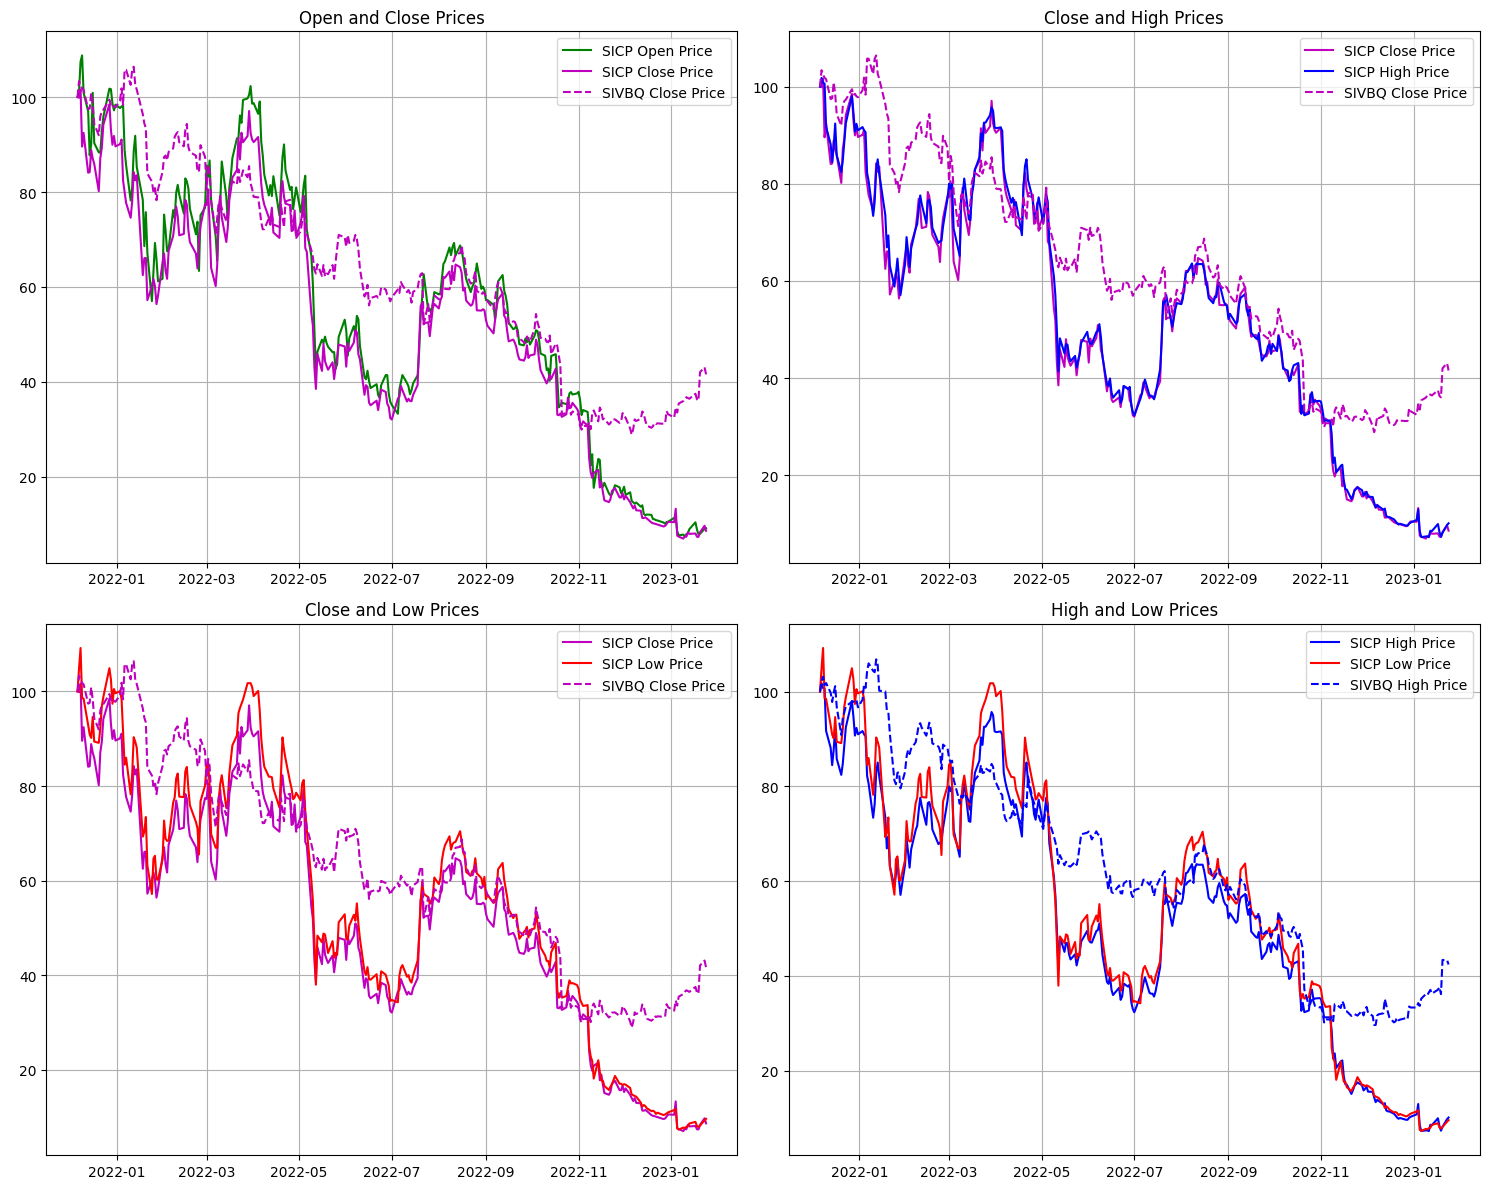

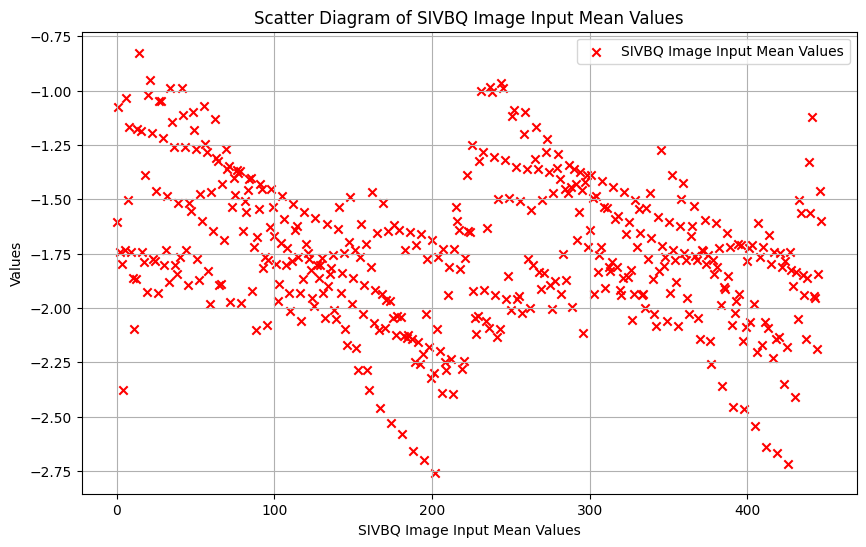

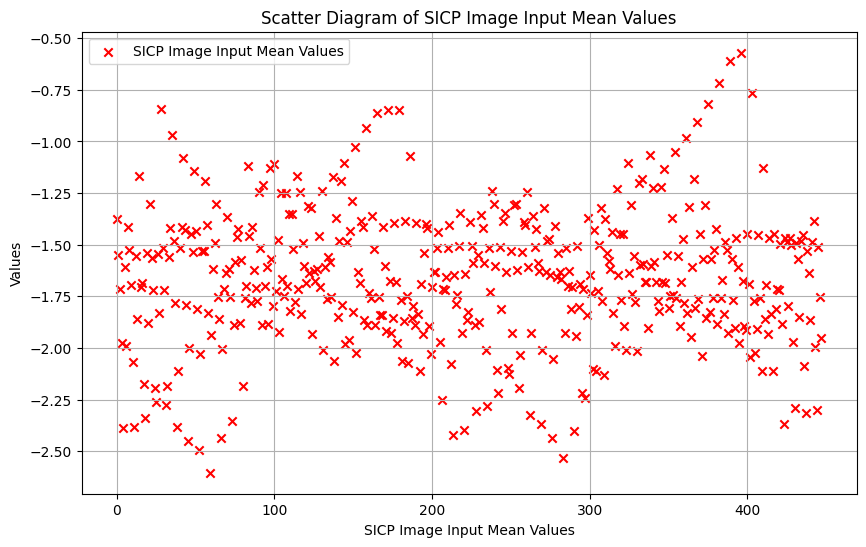

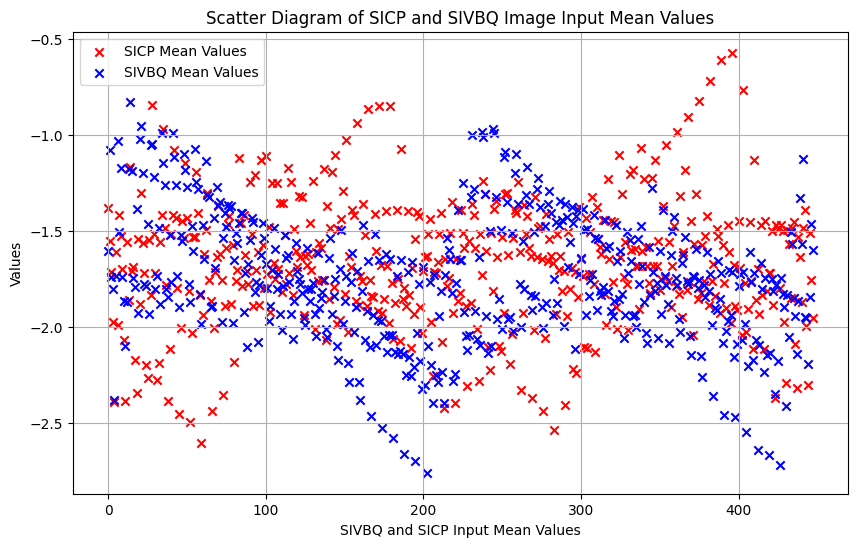

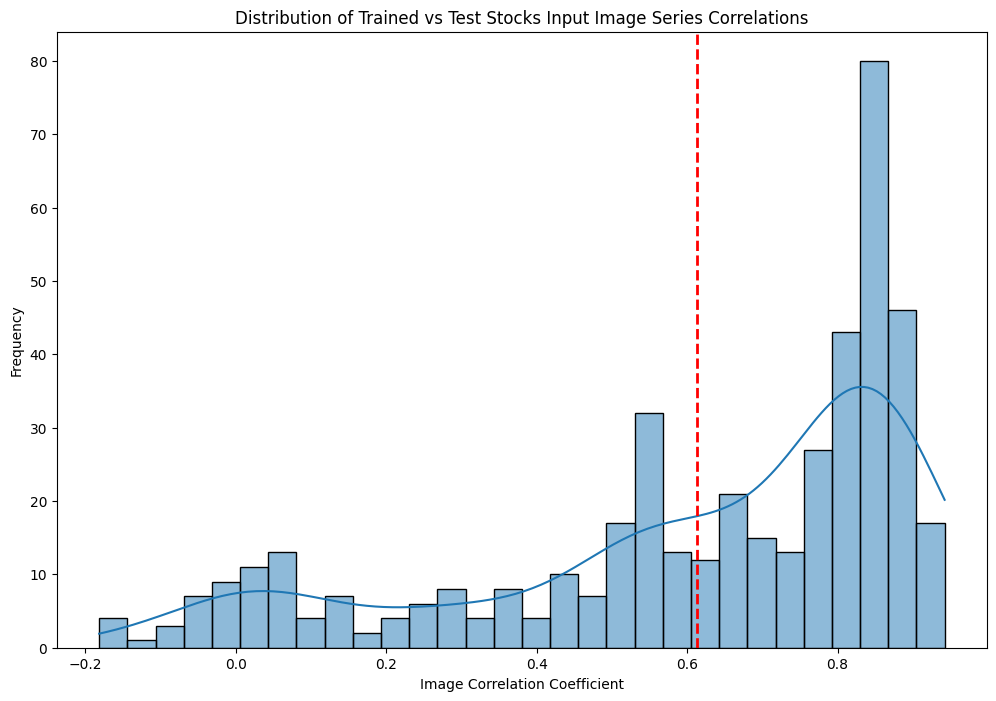

trained versus test stocks image series mean correlation 0.6137635


In [30]:
#plot graphs

#plot data comparing stock prices
plot_data.compare_stocks(index_ticker,test_stock_ticker,stock_dataset_df, start_date, end_date)

#plot train stock mean inputs
plot_data.scatter_diagram_onevar_plot_mean(stack_input, train_stock_ticker)

#plot predicted stock mean inputs
plot_data.scatter_diagram_onevar_plot_mean(test_stack_input, test_stock_ticker)

#scatter actual vs predicted
plot_data.scatter_diagram_twovar_plot_mean(test_stock_ticker,train_stock_ticker,test_stack_input, stack_input)

#plot trained versus test stocks image series mean correlations
plot_data.plot_image_correlations(image_series_correlations, image_series_mean_correlation)
print("trained versus test stocks image series mean correlation",image_series_mean_correlation)

## Bayesian Optimization for CNN Hyperparameters

In [31]:
def CNN_Optimization(output_conv_1, 
                     output_conv_2,
                     dropout_probab,
                     learning_rate,
                     momentum,
                     train_loader,test_loader,
                     iteration=None):
    
    output_conv_1 = int(output_conv_1)
    output_conv_2 = int(output_conv_2)
    
    net = Net(output_conv_1=output_conv_1, output_conv_2=output_conv_2,dropout_probab=dropout_probab)
    net.to(device)

    Train(learning_rate=learning_rate, train_loader=train_loader, net=net, momentum=momentum)

    if iteration is not None:
        helper_functions.Save_BayesOpt_Model(iteration,net)

    stack_input, predicted, actual, accuracy, percentage_diffs, mean_percentage_diff = Test(test_loader=test_loader,net=net)
    
    print("accuracy received",accuracy)

    return accuracy

In [32]:
def Optimize():
    
    train_loader,test_loader = load_data.Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, test_size, batch_size=batch_size, train_shuffle=False)
    
    iteration_counter = [0]

    def cnn_correct_pct_wrapper(output_conv_1, output_conv_2, learning_rate, dropout_probab, momentum):
        result = CNN_Optimization(output_conv_1, output_conv_2, learning_rate, dropout_probab, momentum, train_loader, test_loader, iteration=iteration_counter[0])
        iteration_counter[0] += 1
        return result
    #cnn_correct_pct = partial(CNN_Optimization, train_loader = train_loader, test_loader = test_loader)

    # Bounded region of parameter space
    pbounds = {'output_conv_1': (40, 80),
               'output_conv_2': (8, 16), 
               'learning_rate': (0.00001, 0.0001), 
               'dropout_probab': (0.0, 0.5), 
               'momentum': (0.8, 1.0)}

    optimizer = BayesianOptimization(
        f = cnn_correct_pct_wrapper,
        pbounds=pbounds,
        random_state=1,
        )

    #n_iter:steps of bayesian optimization you want to perform
    #init_points:steps of random exploration
    optimizer.maximize(init_points=10, n_iter=10,)

    with open(f'optimizer_results.txt', 'a') as file:
        for i, res in enumerate(optimizer.res):
            print(f"Iteration {i}: \n\t{res}")
            file.write("\n\nIteration {}: \n\t{}".format(i, res))

    optimizer_max_result = optimizer.max
    print("optimizer result:\n",optimizer.max)

    with open(f'optimizer_results.txt', 'a') as file:
        file.write('\noptimizer results:\n' + str(optimizer_max_result))

In [33]:
# comment out to not run bayesian opt
#Optimize()

In [34]:
# example to reconstruct Net model design. Enter optimizer_results.txt scenario variable results used to validate the net design model inference result matches the optimizer_results.txt output
# dropout_probab = 0.4473033317519236
# learning_rate = 1.7653979023280013e-05
# momentum = 0.8078109566465765
# output_conv_1 = int(46.7)
# output_conv_2 = int(15.0)

# net = Net(name='Classification Net', filter_size_1=filter_size_1, filter_size_2=filter_size_2,
#             filter_size_3=filter_size_3, stride=stride,
#             image_resolution_x=32,image_resolution_y=32,
#             output_conv_1=output_conv_1, output_conv_2=output_conv_2,
#             output_FC_1=output_FC_1, output_FC_2=output_FC_2,
#             final_FCLayer_outputs=final_FCLayer_output,
#             dropout_probab=dropout_probab)

# net.to(device)
# net.parameters()

# net = Load_BayesOpt_Model("5",net)

# predicted_np, actual_np, accuracy, percentage_diffs, mean_percentage_diff, average_percentage_diff, df = Test_And_Report(net)
